In [1]:
import json
import pandas as pd
from skimage.io import imread
import cv2
from tqdm import tqdm, tqdm_notebook
import pythreshold
from pythreshold.local_th import wolf, feng, niblack, bernsen
from pythreshold.utils import test_thresholds
from scipy.spatial.distance import cdist

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
DATA_FOLDER = "./tocorrect/"
data = pd.read_csv("./tocorrect/crop_regions.csv")

In [3]:
def str_to_dict(s):
    return json.loads(s.replace("u'", "'").replace("\'", "\""))

In [4]:
data["crop_regions"] = data["crop_regions"].apply(str_to_dict)

In [5]:
data

,receipt_id,file_path,crop_regions
0,3487830,receipt_files/3487830.jpg,"[[{'y': 46, 'x': 1032}, {'y': 1212, 'x': 995},..."
1,3490860,receipt_files/3490860.jpg,"[[{'y': 288, 'x': 531}, {'y': 285, 'x': 731}, ..."
2,3491247,receipt_files/3491247.jpg,"[[{'y': 393, 'x': 546}, {'y': 383, 'x': 669}, ..."
3,3487613,receipt_files/3487613.jpg,"[[{'y': 222, 'x': 1927}, {'y': 938, 'x': 1891}..."
4,3488933,receipt_files/3488933.jpg,"[[{'y': 155, 'x': 1343}, {'y': 177, 'x': 1667}..."
5,3488767,receipt_files/3488767.jpg,"[[{'y': 623, 'x': 795}, {'y': 724, 'x': 866}, ..."
6,3490818,receipt_files/3490818.jpg,"[[{'y': 279, 'x': 1238}, {'y': 1701, 'x': 1234..."
7,3488055,receipt_files/3488055.jpg,"[[{'y': 91, 'x': 1065}, {'y': 108, 'x': 2704},..."
8,3489461,receipt_files/3489461.jpg,"[[{'y': 39, 'x': 395}, {'y': 256, 'x': 392}, {..."
9,3489909,receipt_files/3489909.jpg,"[[{'y': 239, 'x': 1529}, {'y': 2048, 'x': 1536..."


In [58]:
def find_closest(old_x, old_y, possible_x, possible_y, n_closest=1):
    possible_x = np.array(possible_x)
    possible_y = np.array(possible_y)
    
    old_points = np.array(list(zip(old_x, old_y)))
    possible_points = list(zip(possible_x, possible_y))
    dists = cdist(old_points, possible_points)
    new_indecies = np.argpartition(dists, n_closest, axis=1)[:, :n_closest]
    if n_closest == 1:
        new_indecies = np.expand_dims(new_indecies, 1)
    print(new_indecies.shape)
    new_x = [possible_x[closest_ind].mean() for closest_ind in new_indecies]
    new_y = [possible_y[closest_ind].mean() for closest_ind in new_indecies]
        
    return new_x, new_y

In [59]:
def apply_canny(crop):
    high_thresh, thresh_im = cv2.threshold(crop, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    lowThresh = 0.5 * high_thresh
    canny = cv2.Canny(crop, lowThresh, high_thresh)
    return canny

In [68]:
def increase_number_of_points_in_polygon(points):
    new_points = list()
    for i in range(1, len(points)):
        new_points.append(points[i - 1])
        new_points.append((points[i - 1] * 2 + points[i]) / 3.)
        new_points.append((points[i - 1] + points[i] * 2) / 3.)
        #new_points.append((points[i - 1] * 3 + points[i]) / 4.)
        #new_points.append((points[i - 1] + points[i]) / 2.)
        #new_points.append((points[i - 1] + points[i] * 3) / 4.)
        new_points.append(points[i])
    return new_points

(44, 1, 1)


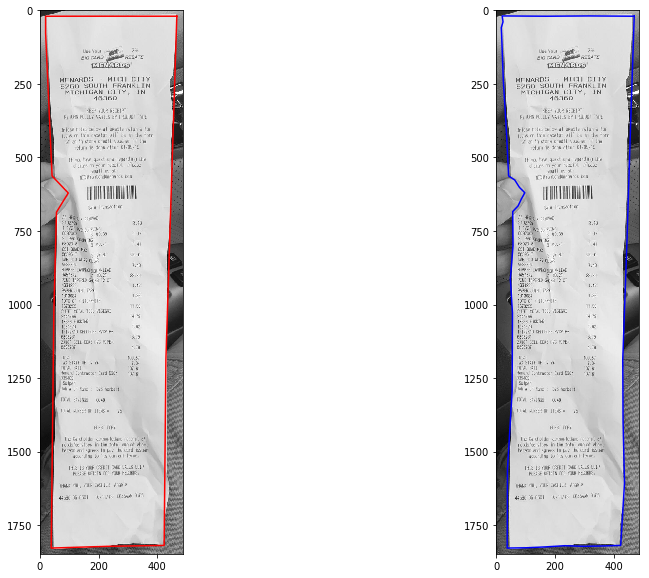

(64, 1, 1)


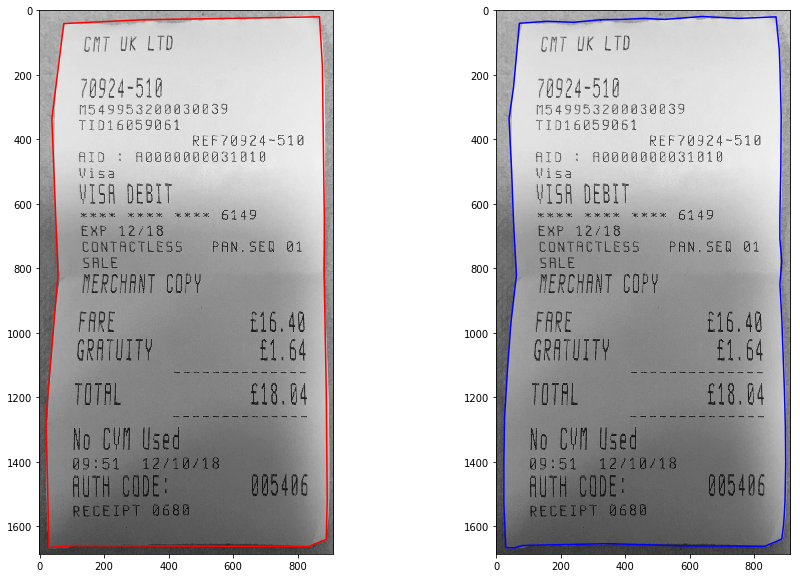

(80, 1, 1)


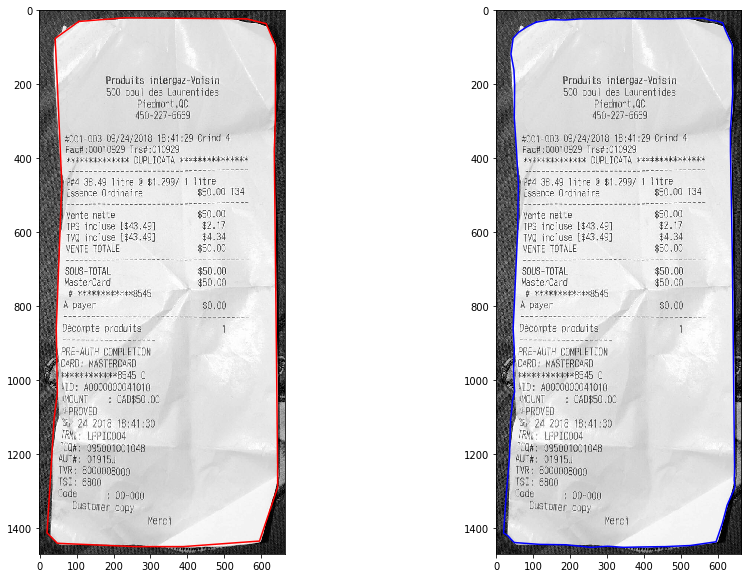

(48, 1, 1)


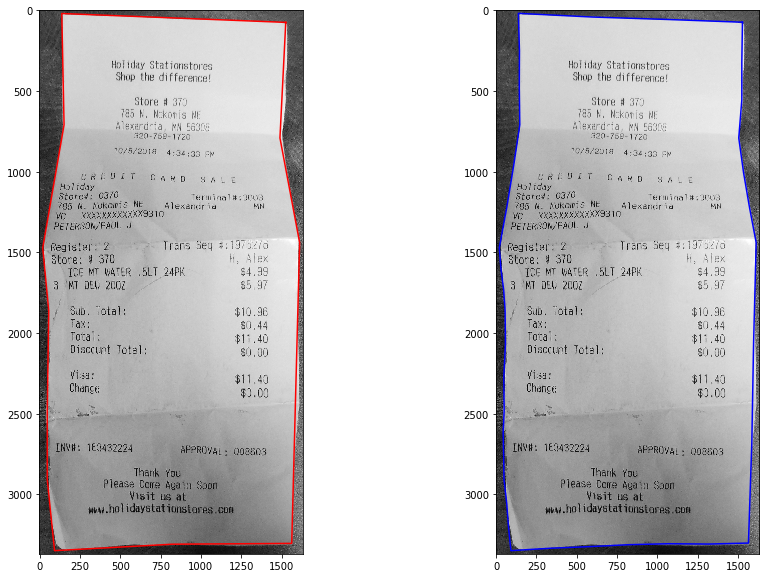

(56, 1, 1)


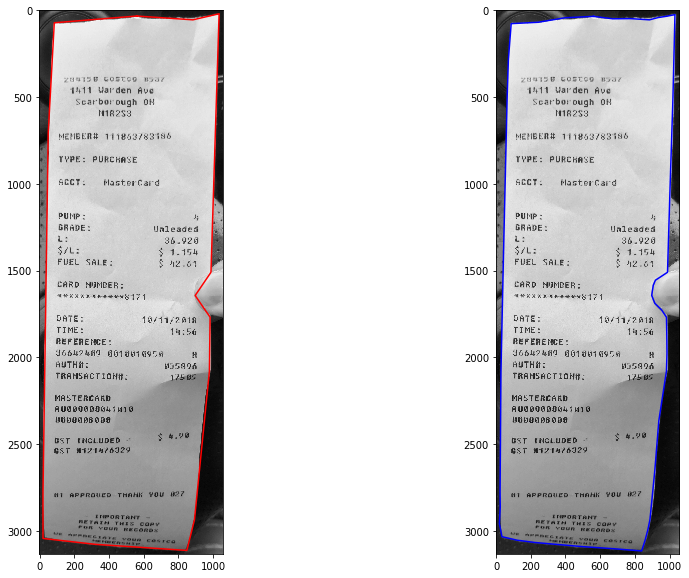

(52, 1, 1)


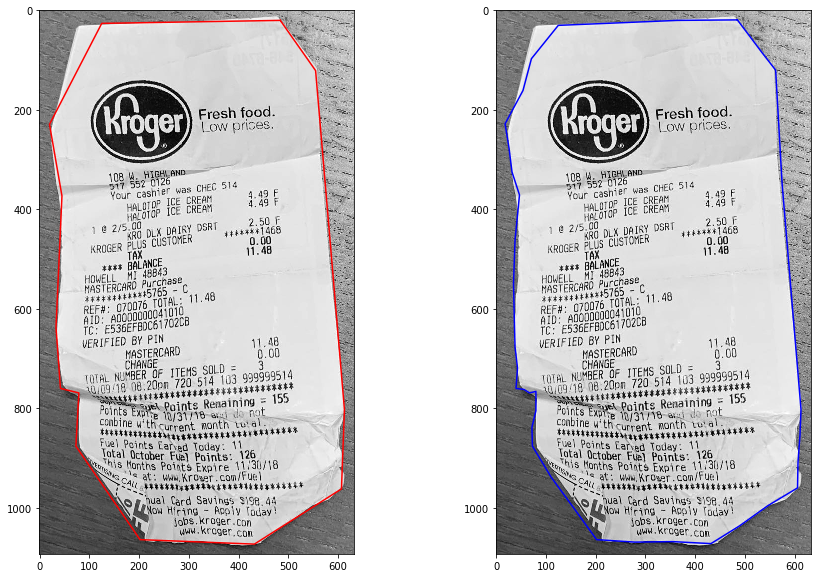

(32, 1, 1)


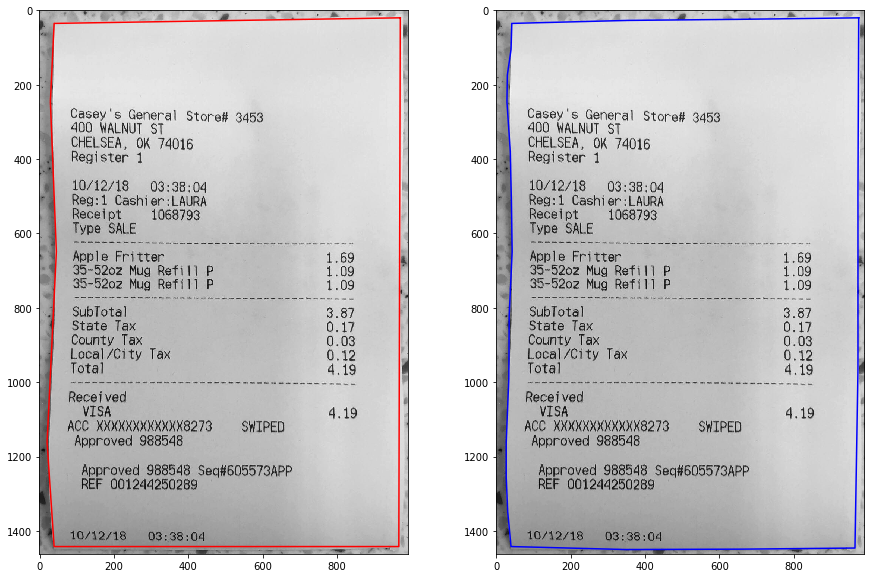

(48, 1, 1)


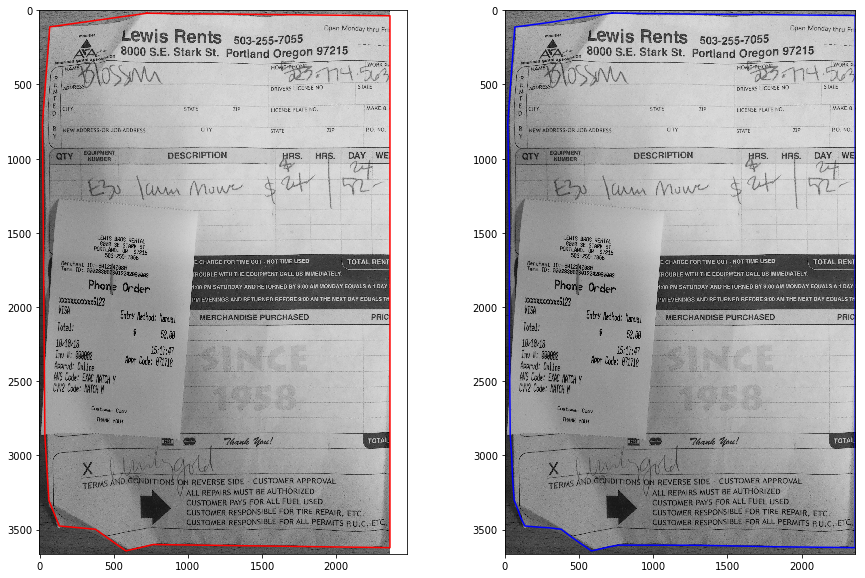

(92, 1, 1)


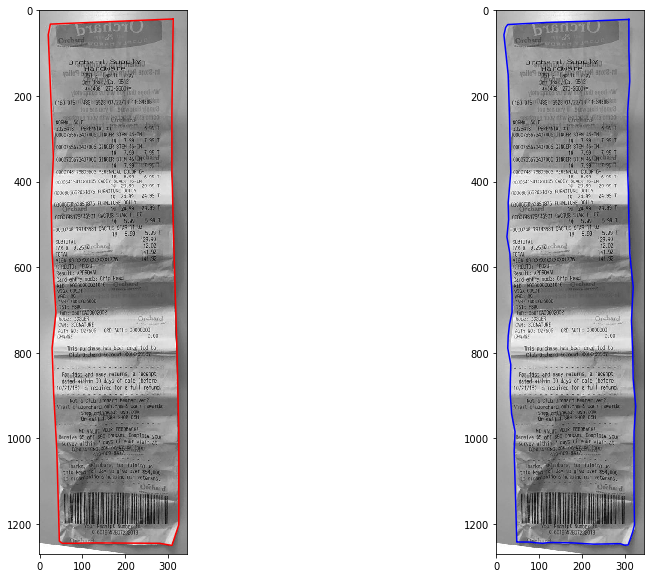

(28, 1, 1)


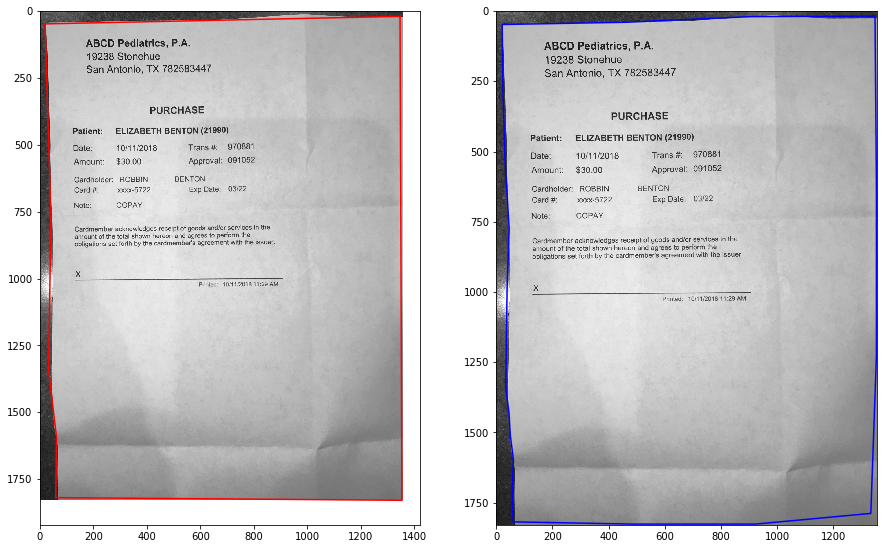

(44, 1, 1)


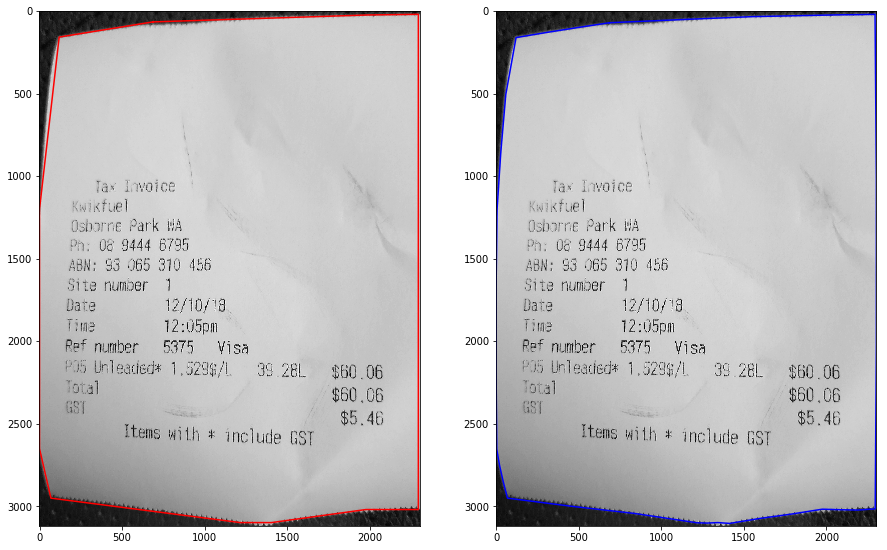

In [70]:
#lsd = cv2.ximgproc.createFastLineDetector()
offset = 20
for i, row in data.iterrows():
    img = cv2.imread(DATA_FOLDER + row["file_path"], 0)
    #img = cv2.GaussianBlur(img, (5, 5), 0)
    
    line_x = [d["x"] for d in row["crop_regions"][0]]
    line_x.append(line_x[0])
    
    line_y = [d["y"] for d in row["crop_regions"][0]]
    line_y.append(line_y[0])
    
    crop = img[max(min(line_y) - offset, 0) : min(max(line_y) + offset, img.shape[0]), 
               max(min(line_x) - offset, 0) : min(max(line_x) + offset,  img.shape[1])].copy()
    
    crop_line_x = [x - max(min(line_x) - offset, 0) for x in line_x]
    crop_line_y = [y - max(min(line_y) - offset, 0) for y in line_y]
    
    bin_crop = np.array(crop >= bernsen.bernsen_threshold(crop), dtype=np.uint8)
    contours, hierarchy = cv2.findContours(bin_crop * 255, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    out = cv2.drawContours(np.zeros_like(crop), contours, -1, 255, 1)
    possible_y, possible_x = np.nonzero(out)
    
    old_line_y = increase_number_of_points_in_polygon(crop_line_y)
    old_line_x = increase_number_of_points_in_polygon(crop_line_x)
    new_x, new_y = find_closest(old_line_x, old_line_y, possible_x, possible_y, n_closest=1)

    f, axs = plt.subplots(1, 2, figsize=(15, 10))
    #axs[0].imshow(img, cmap='gray')
    #axs[0].plot(line_x, line_y, color="red")
    
    axs[0].imshow(crop, cmap="gray")
    axs[0].plot(crop_line_x, crop_line_y, color="red")
    
    axs[1].imshow(crop, cmap="gray")
    axs[1].plot(new_x, new_y, color="blue")
    #axs[1].scatter(new_x, new_y, linewidths=3, color="blue", alpha=0.3)
    #axs[1].scatter(crop_line_x, crop_line_y, linewidths=3, color="red", alpha=0.3)
    #axs[2].imshow(out, cmap="gray")
    plt.show()